In [1]:
import re, os, glob
import image_slicer
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
#os.environ["CUDA_VISIBLE_DEVICES"]="5,6,7,8"
os.environ["CUDA_VISIBLE_DEVICES"]="8"

In [2]:
from fastai import *
from fastai.vision import *
from fastai.core import *
from fastai.callbacks.hooks import *
from fastai.metrics import error_rate
import matplotlib.pyplot as plt
import re, os, glob
import torch
from PIL import Image

In [3]:
BS=8
VALID_PCT=0.2

In [4]:
def symmetrise_data(df_i, col_name_output='treatment', n_samples=None, remove_one=False):
    
    if n_samples is None:
        n_samples = min(df_i[df_i[col_name_output] == 'ab'].shape[0], 
                       df_i[df_i[col_name_output] == 'veh'].shape[0])
        
    if remove_one:
        n_samples -= 1
    
    
    tmp = pd.concat([df_i[df_i[col_name_output] == 'ab'].sample(n_samples), 
                     df_i[df_i[col_name_output] == 'veh'].sample(n_samples)], axis=0)
    
    return tmp

In [5]:
torch.cuda.device_count()

1

In [6]:
#torch.cuda.set_device(5)

In [7]:
#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
#os.environ["CUDA_VISIBLE_DEVICES"]="1,2,3,4"
#torch.cuda.set_device([1,2])

In [8]:
torch.cuda.current_device()

0

In [9]:
os.getcwd()

'/mnt/sdf/adam'

In [10]:
base_path = os.path.join('/mnt', 'sdf')
base_path

'/mnt/sdf'

In [11]:
#path_to_images = os.path.join('cy5_data', 'all_images')
#path_to_images

In [12]:
path_to_images = os.path.join(base_path, 'training_data')
path_to_images

'/mnt/sdf/training_data'

In [13]:
path_to_dfs = os.path.join(base_path, 'training_data', 'dfs')
path_to_dfs

'/mnt/sdf/training_data/dfs'

In [14]:
# create a single dataframe with all file names and labels
dfs_filenames = glob.glob(os.path.join(path_to_dfs, '*.csv'))

dfs = []
for filename_i in dfs_filenames:
    dfs.append(pd.read_csv(filename_i))
    
dfs = pd.concat(dfs, axis=0)

In [15]:
dfs[['filename_new', 'treatment']].shape

(16548, 2)

In [16]:
# validation of the data set

a_0 = dfs.filename_new.tolist()
a_0_new = ['/mnt/sdf/training_data/' + i for i in a_0]
b_0 = glob.glob(os.path.join(path_to_images, '*.tif'))

print(len(a_0_new))
print(len(b_0))

missing_files = list(set(a_0_new) - set(b_0))
print(len(missing_files))

16548
16524
24


In [17]:
missing_files = [re.sub('/mnt/sdf/training_data/', '',i) for i in missing_files]
missing_files[:5]

['caroline_2018 fixations_4 - april_cmap 5 - fix 15-3-18_3 - doxylamine_40x_6-4-18_40x_assay plate 0_3_2018.04.06.20.10.49_b - 4(fld 17 wv red - cy5).tif',
 'caroline_2018 fixations_4 - april_cmap 5 - fix 15-3-18_1 - pres-857 levobunolol +_40x_6-4-18_40x_assay plate 0_1_2018.04.06.17.39.49_c - 6(fld 4 wv red - cy5).tif',
 'caroline_2018 fixations_4 - april_cmap 5 - fix 15-3-18_1 - pres-857 levobunolol +_40x_6-4-18_40x_assay plate 0_1_2018.04.06.17.39.49_c - 6(fld 25 wv red - cy5).tif',
 'caroline_2018 fixations_4 - april_cmap 5 - fix 15-3-18_1 - pres-857 levobunolol +_40x_6-4-18_40x_assay plate 0_1_2018.04.06.17.39.49_d - 6(fld 19 wv red - cy5).tif',
 'caroline_2018 fixations_4 - april_cmap 5 - fix 15-3-18_3 - doxylamine_40x_6-4-18_40x_assay plate 0_3_2018.04.06.20.10.49_d - 6(fld 19 wv red - cy5).tif']

In [18]:
missing_files += ['caroline_2018 fixations_4 - april_cmap 5 - fix 15-3-18_3 - doxylamine_40x_6-4-18_40x_assay plate 0_3_2018.04.06.20.10.49_d - 4(fld 28 wv red - cy5).tif']

In [19]:
missing_files

['caroline_2018 fixations_4 - april_cmap 5 - fix 15-3-18_3 - doxylamine_40x_6-4-18_40x_assay plate 0_3_2018.04.06.20.10.49_b - 4(fld 17 wv red - cy5).tif',
 'caroline_2018 fixations_4 - april_cmap 5 - fix 15-3-18_1 - pres-857 levobunolol +_40x_6-4-18_40x_assay plate 0_1_2018.04.06.17.39.49_c - 6(fld 4 wv red - cy5).tif',
 'caroline_2018 fixations_4 - april_cmap 5 - fix 15-3-18_1 - pres-857 levobunolol +_40x_6-4-18_40x_assay plate 0_1_2018.04.06.17.39.49_c - 6(fld 25 wv red - cy5).tif',
 'caroline_2018 fixations_4 - april_cmap 5 - fix 15-3-18_1 - pres-857 levobunolol +_40x_6-4-18_40x_assay plate 0_1_2018.04.06.17.39.49_d - 6(fld 19 wv red - cy5).tif',
 'caroline_2018 fixations_4 - april_cmap 5 - fix 15-3-18_3 - doxylamine_40x_6-4-18_40x_assay plate 0_3_2018.04.06.20.10.49_d - 6(fld 19 wv red - cy5).tif',
 'caroline_2018 fixations_4 - april_cmap 5 - fix 15-3-18_1 - pres-857 levobunolol +_40x_6-4-18_40x_assay plate 0_1_2018.04.06.17.39.49_f - 9(fld 22 wv red - cy5).tif',
 'caroline_2018 f

In [20]:
dfs.treatment.value_counts()

veh    8276
ab     8272
Name: treatment, dtype: int64

In [21]:
dfs = dfs[~(dfs.filename_new.isin(missing_files))].copy()

In [22]:
dfs.treatment.value_counts()

ab     8264
veh    8260
Name: treatment, dtype: int64

In [23]:
#treated = glob.glob(os.path.join(base_path, path_to_images, 'treated/*.*'))
#print(treated[:5])

In [24]:
#os.listdir(os.path.join(base_path, path_to_images, 'treated'))[:5]

In [25]:
#dfs.filename_new.iloc[0]

In [29]:
#plt.imshow(plt.imread('_CMAP_7_-_Fix_12-4-18_C1_Treated_C_-_4(fld_7_wv_Red_-_Cy5).tif'))

In [30]:
#num_tiles = 4
#tiles = image_slicer.slice('_CMAP_7_-_Fix_12-4-18_C1_Treated_C_-_4(fld_7_wv_Red_-_Cy5).tif', num_tiles)

In [31]:
#tiles

In [32]:
#plt.imshow(plt.imread('_CMAP_7_-_Fix_12-4-18_C1_Treated_C_-_4(fld_7_wv_Red_-_Cy5)_02_02.png'))

In [33]:
#plt.imshow(plt.imread('_CMAP_7_-_Fix_12-4-18_C1_Treated_C_-_4(fld_7_wv_Red_-_Cy5)_01_02.png'))

In [34]:
'''
treated_file_names = []
for file in os.listdir(os.path.join(base_path, path_to_images, 'treated')):
    if file.endswith(".tif"):
        treated_file_names.append((os.path.join(path_to_images, 'treated', file)))
        
untreated_file_names = []
for file in os.listdir(os.path.join(base_path, path_to_images, 'untreated')):
    if file.endswith(".tif"):
        untreated_file_names.append((os.path.join(path_to_images, 'untreated', file)))        
'''

'\ntreated_file_names = []\nfor file in os.listdir(os.path.join(base_path, path_to_images, \'treated\')):\n    if file.endswith(".tif"):\n        treated_file_names.append((os.path.join(path_to_images, \'treated\', file)))\n        \nuntreated_file_names = []\nfor file in os.listdir(os.path.join(base_path, path_to_images, \'untreated\')):\n    if file.endswith(".tif"):\n        untreated_file_names.append((os.path.join(path_to_images, \'untreated\', file)))        \n'

In [35]:
#untreated = glob.glob(os.path.join(base_path, path_to_images, 'untreated/*.*'))
#print(untreated[:5])

In [36]:
#len(untreated)

In [34]:
'''
df_untreated = pd.concat([pd.DataFrame(untreated_file_names, columns=['name']), pd.DataFrame(len(untreated_file_names) * [0], columns=['label'])], axis=1)
df_treated = pd.concat([pd.DataFrame(treated_file_names, columns=['name']), pd.DataFrame(len(treated_file_names) * [1], columns=['label'])], axis=1)
df_data_images_cy5 = pd.concat([df_untreated, df_treated], axis=0)

df_data_images_cy5_bs_8 = pd.concat([df_data_images_cy5[df_data_images_cy5.label==0].sample(1432), 
                                     df_data_images_cy5[df_data_images_cy5.label==1].sample(1432)]).reset_index(drop=True).copy()
'''

"\ndf_untreated = pd.concat([pd.DataFrame(untreated_file_names, columns=['name']), pd.DataFrame(len(untreated_file_names) * [0], columns=['label'])], axis=1)\ndf_treated = pd.concat([pd.DataFrame(treated_file_names, columns=['name']), pd.DataFrame(len(treated_file_names) * [1], columns=['label'])], axis=1)\ndf_data_images_cy5 = pd.concat([df_untreated, df_treated], axis=0)\n\ndf_data_images_cy5_bs_8 = pd.concat([df_data_images_cy5[df_data_images_cy5.label==0].sample(1432), \n                                     df_data_images_cy5[df_data_images_cy5.label==1].sample(1432)]).reset_index(drop=True).copy()\n"

In [35]:
#df_data_images_cy5.head()

In [36]:
#data = (ImageItemList.from_csv(path=data_path, 
#                              csv_name='rsna_train_labels.csv',
#                              folder='train_images',
#                              suffix='.dcm'
#                             )
#        .random_split_by_pct()
#        .label_from_df(cols='Target')
#        .transform(get_transforms(), size=224)
#        .databunch())


In [37]:
#df_data_images_cy5_bs_8.label.value_counts()

## Training at 256 resolution

In [30]:
'''
data = ImageDataBunch.from_df(base_path, 
                              df_data_images_cy5_bs_8,
                              ds_tfms=get_transforms(),
                              valid_pct=VALID_PCT, 
                              bs=32,
                              size=256).normalize(imagenet_stats)
'''                              

'\ndata = ImageDataBunch.from_df(base_path, \n                              df_data_images_cy5_bs_8,\n                              ds_tfms=get_transforms(),\n                              valid_pct=VALID_PCT, \n                              bs=32,\n                              size=256).normalize(imagenet_stats)\n'

In [77]:
data = ImageDataBunch.from_df(path_to_images, 
                              dfs[['filename_new', 'treatment']],
                              ds_tfms=get_transforms(),
                              valid_pct=VALID_PCT, 
                              bs=32,
                              size=256).normalize(imagenet_stats)

In [22]:
#data.show_batch()

In [78]:
learn = create_cnn(data, models.resnet152, metrics=accuracy,  bn_final=True)
learn.model = torch.nn.DataParallel(learn.model)

In [79]:
# learn.load('resnet152_256');

In [80]:
#learn = unet_learner(data, models.resnet34, metrics=accuracy)
#learn.model = torch.nn.DataParallel(learn.model)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


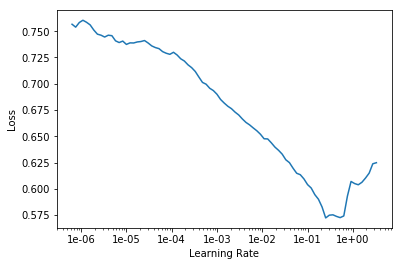

In [81]:
learn.lr_find()
learn.recorder.plot()

In [82]:
learn.fit_one_cycle(3, 3e-2)

In [96]:
learn.save('resnet152_256_lg')

In [97]:
learn.load('resnet152_256_lg');

In [83]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


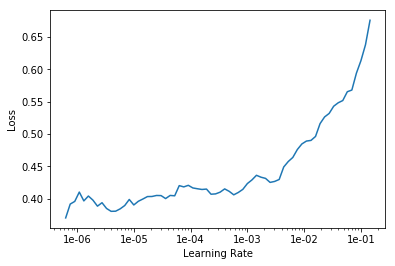

In [99]:
learn.lr_find()
learn.recorder.plot()

In [84]:
learn.fit_one_cycle(10, slice(1e-6, 1e-3))

In [36]:
#learn.model = learn.model.module

In [85]:
learn.save('resnet152_256_lg')

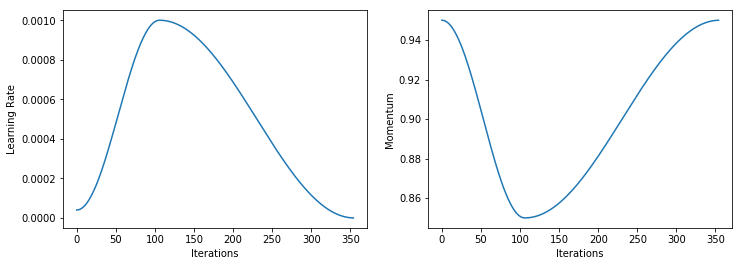

In [38]:
learn.recorder.plot_lr(show_moms=True)

In [ ]:
# original saved file with DataParallel
#state_dict = torch.load('resnet152_1024')
# create new OrderedDict that does not contain `module.`
#from collections import OrderedDict
#new_state_dict = OrderedDict()
#for k, v in state_dict.items():
#    name = k[7:] # remove `module.`
#    new_state_dict[name] = v
# load params
#model.load_state_dict(new_state_dict)

In [ ]:
#model.load_state_dict(torch.load('./resnet152_1024'), strict=False)

In [86]:
ci = ClassificationInterpretation.from_learner(learn)

In [ ]:
ci.confusion_matrix()

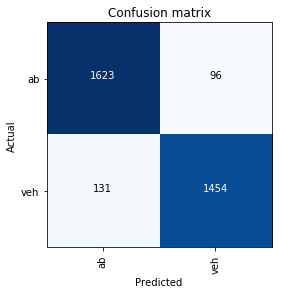

In [87]:
ci.plot_confusion_matrix()

In [41]:
ci.most_confused()

[(1, 0, 50)]

In [ ]:
ci.plot_top_losses(25, figsize=(20,20))

## Training at 512 resolution

In [20]:
'''
data = ImageDataBunch.from_df(base_path, 
                              df_data_images_cy5,
                              ds_tfms=get_transforms(), 
                              bs=32,
                              size=512).normalize(imagenet_stats)
'''                              

'\ndata = ImageDataBunch.from_df(base_path, \n                              df_data_images_cy5,\n                              ds_tfms=get_transforms(), \n                              bs=32,\n                              size=512).normalize(imagenet_stats)\n'

In [25]:
data = ImageDataBunch.from_df(path_to_images, 
                              dfs[['filename_new', 'treatment']],
                              ds_tfms=get_transforms(),
                              valid_pct=VALID_PCT, 
                              bs=32,
                              size=512).normalize(imagenet_stats)

In [25]:
learn = create_cnn(data, models.resnet152, metrics=accuracy,  bn_final=True)
learn.load('resnet152_256_lg')
learn.model = torch.nn.DataParallel(learn.model)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


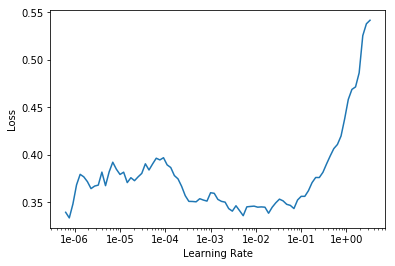

In [26]:
learn.lr_find()
learn.recorder.plot()

In [27]:
learn.fit_one_cycle(5, max_lr = 1e-3)#max_lr=slice(1e-4, 1e-2))

In [28]:
learn.fit_one_cycle(3, max_lr = 1e-4)

In [29]:
learn.model = learn.model.module
learn.save('resnet152_512_froz')

In [31]:
learn = create_cnn(data, models.resnet152, metrics=accuracy, bn_final=True)
learn.load('resnet152_512_froz');
learn.model = torch.nn.DataParallel(learn.model)

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [32]:
learn.freeze_to(-50)

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [33]:
learn.fit_one_cycle(2, max_lr = slice(1e-6, 1e-3), moms=(0.8, 0.7))

In [40]:
learn.model = learn.model.module
learn.save('resnet152_512_unfreeze_50')

In [43]:
learn = create_cnn(data, models.resnet152, metrics=accuracy, bn_final=True)
learn.load('resnet152_512_unfreeze_50');
learn.model = torch.nn.DataParallel(learn.model)

In [39]:
learn.fit_one_cycle(2, max_lr = slice(1e-5, 1e-3), moms=(0.8, 0.7))

In [44]:
learn.freeze_to(-100)

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [45]:
learn.fit_one_cycle(5, max_lr = slice(1e-6, 1e-3), moms=(0.8, 0.7))

In [46]:
learn.model = learn.model.module
learn.save('resnet152_512_unfreeze_100')

In [47]:
learn = create_cnn(data, models.resnet152, metrics=accuracy, bn_final=True)
learn.load('resnet152_512_unfreeze_100');
learn.model = torch.nn.DataParallel(learn.model)

In [48]:
learn.fit_one_cycle(1, max_lr = slice(1e-6, 1e-3), moms=(0.8, 0.7))

In [49]:
learn.model = learn.model.module
learn.save('resnet152_512_unfreeze_100')

In [50]:
learn = create_cnn(data, models.resnet152, metrics=accuracy, bn_final=True)
learn.load('resnet152_512_unfreeze_100');
learn.model = torch.nn.DataParallel(learn.model)

In [51]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


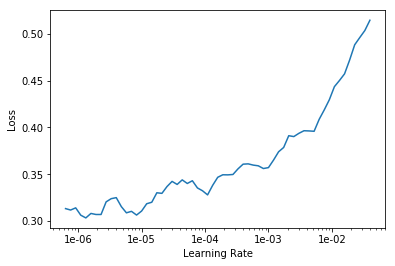

In [58]:
learn.lr_find()
learn.recorder.plot()

In [52]:
learn.fit_one_cycle(3, max_lr = slice(5e-7, 1e-4), moms=(0.8, 0.7))

In [53]:
learn.model = learn.model.module
learn.save('resnet152_512_lg_bn_final')

In [27]:
learn = create_cnn(data, models.resnet152, metrics=accuracy, bn_final=True).load('resnet152_512_lg_bn_final');

In [22]:
learn.model = learn.model.module

In [28]:
ci = ClassificationInterpretation.from_learner(learn)

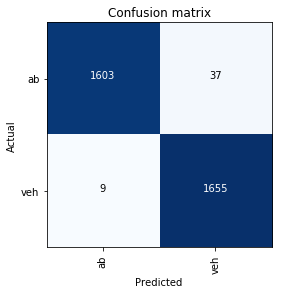

In [29]:
ci.plot_confusion_matrix()

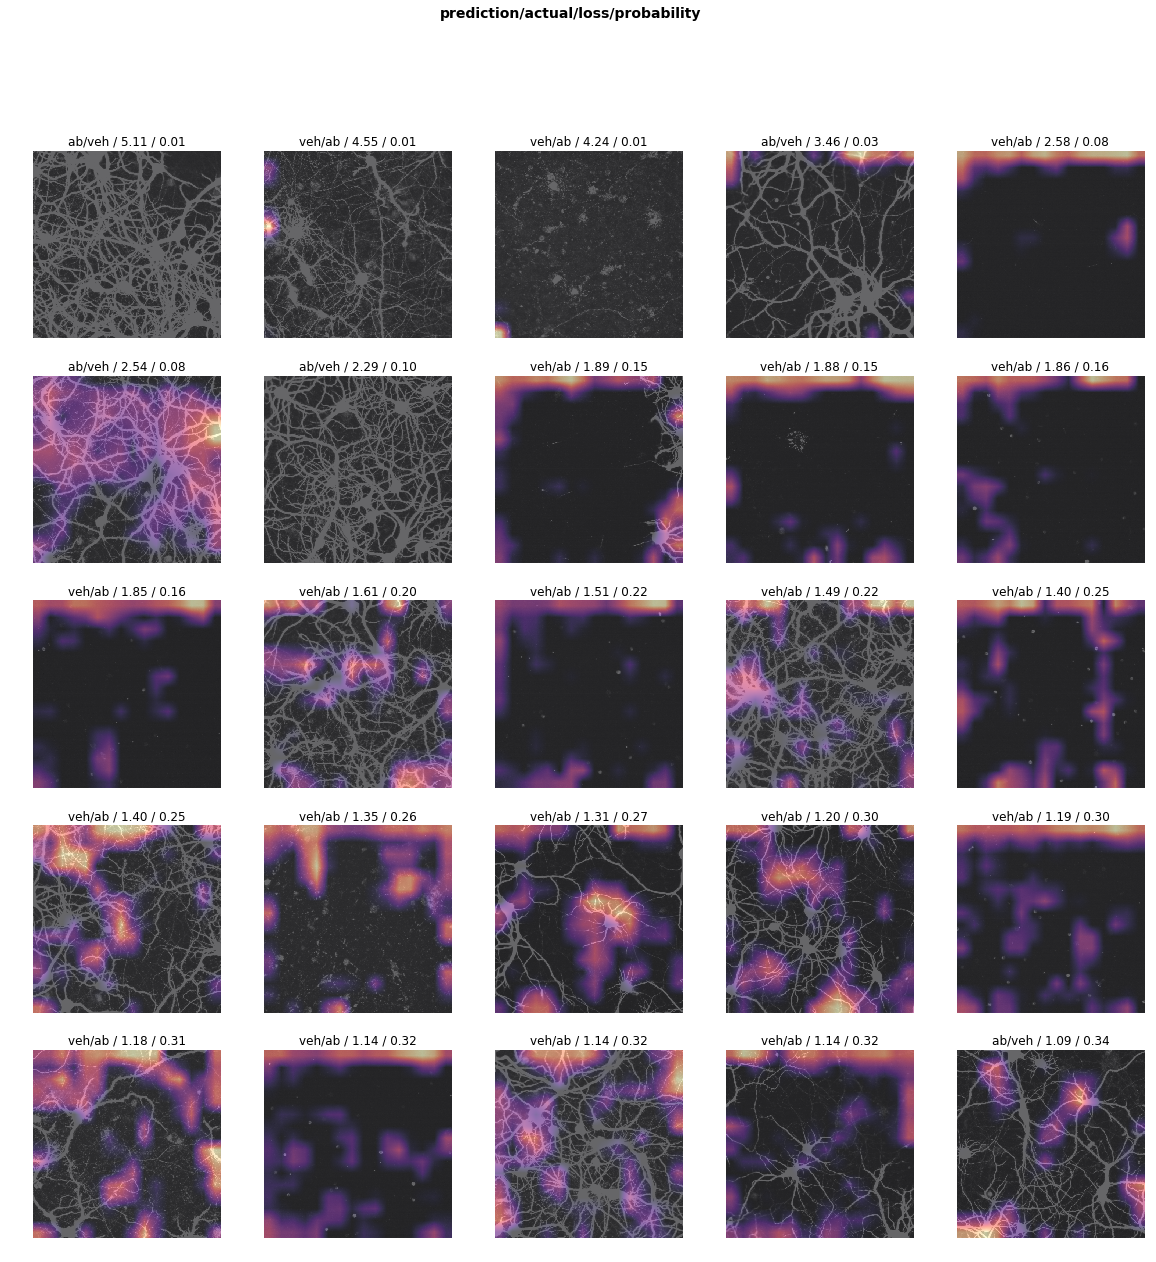

In [30]:
ci.plot_top_losses(25, figsize=(20,20))

## Training at 1024 resolution

In [56]:
'''
data = ImageDataBunch.from_df(base_path, 
                              df_data_images_cy5,
                              ds_tfms=get_transforms(), 
                              valid_pct=VALID_PCT,
                              bs=16,
                              size=1024).normalize(imagenet_stats)
'''

'\ndata = ImageDataBunch.from_df(base_path, \n                              df_data_images_cy5,\n                              ds_tfms=get_transforms(), \n                              valid_pct=VALID_PCT,\n                              bs=16,\n                              size=1024).normalize(imagenet_stats)\n'

In [23]:
#data = ImageDataBunch.from_df(path_to_images, 
#                              symmetrise_data(dfs[['filename_new', 'treatment']], n_samples=101, remove_one=True),
#                              ds_tfms=get_transforms(),
#                              valid_pct=VALID_PCT, 
#                              bs=10,
#                              size=1024).normalize(imagenet_stats)

In [24]:
data = ImageDataBunch.from_df(path_to_images, 
                              symmetrise_data(dfs[['filename_new', 'treatment']], remove_one=True),
                              ds_tfms=get_transforms(do_flip=True, 
                                                     flip_vert=True, 
                                                     max_rotate=None, 
                                                     max_zoom=1.0, 
                                                     max_warp=None),
                              valid_pct=VALID_PCT, 
                              bs=8,
                              size=1024).normalize(imagenet_stats)

New experiments (11-June-2019)

In [25]:
learn = cnn_learner(data, models.resnet152, metrics=accuracy, bn_final=True, ps=0.5).load('resnet152_1024_lg_first_fit_v03')
learn.model = torch.nn.DataParallel(learn.model)

In [26]:
ci = ClassificationInterpretation.from_learner(learn)

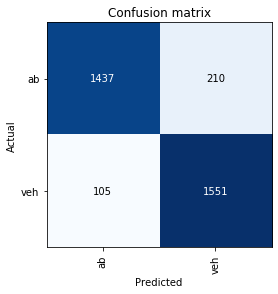

In [27]:
ci.plot_confusion_matrix()

In [28]:
learn.model = learn.model.module

In [ ]:
ci.plot_top_losses(25, figsize=(20,20))

In [29]:
(1437+1551) / (1437+1551+210+105)

0.9046321525885559

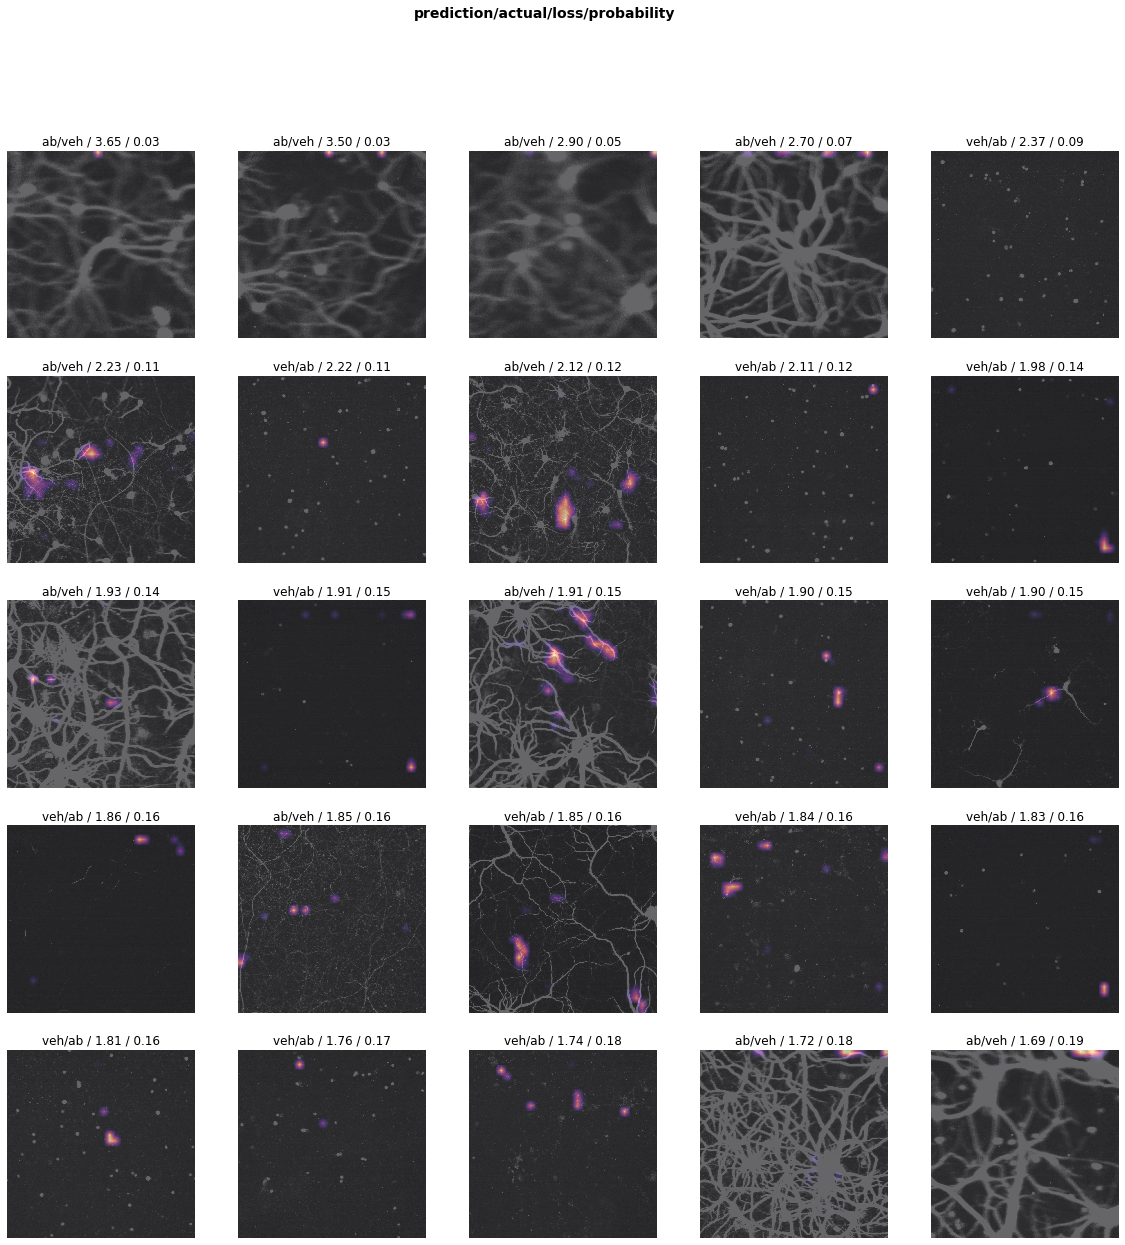

In [30]:
ci.plot_top_losses(25, figsize=(20,20))

In [25]:
learn = create_cnn(data, models.resnet152, metrics=accuracy, bn_final=True).load('resnet152_1024_lg')
learn.model = torch.nn.DataParallel(learn.model)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


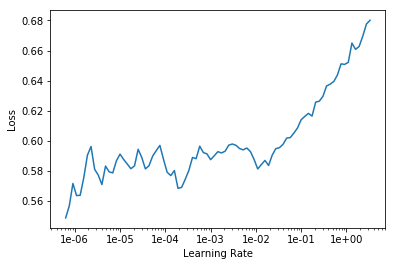

In [26]:
learn.lr_find()
learn.recorder.plot()

In [27]:
learn.fit_one_cycle(3, slice(1e-5))

In [32]:
learn.model = learn.model.module
learn.save('resnet152_1024_lg_first_fit_v03')

In [28]:
learn = cnn_learner(data, models.resnet152, metrics=accuracy, bn_final=True, ps=0.5).load('resnet152_1024_lg_first_fit_v03')
learn.model = torch.nn.DataParallel(learn.model)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


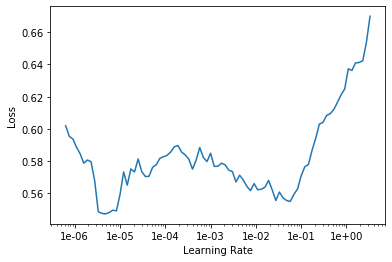

In [29]:
learn.lr_find()
learn.recorder.plot()

### No data augmentation

In [30]:
learn.fit_one_cycle(30, slice(2e-3))

In [35]:
learn.fit_one_cycle(40, slice(1e-5))

In [30]:
learn.model = learn.model.module
learn.save('resnet152_1024_lg_head_40_epochs')

In [35]:
learn = cnn_learner(data, models.resnet152, metrics=accuracy, bn_final=True, ps=0.5).load('resnet152_1024_lg_head_40_epochs')
learn.model = torch.nn.DataParallel(learn.model)

In [36]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


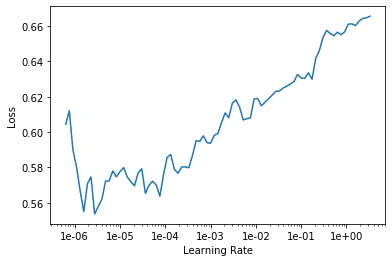

In [37]:
learn.lr_find()
learn.recorder.plot()

In [38]:
learn.fit_one_cycle(3, max_lr=slice(1e-7, 1e-4))

In [39]:
learn.model = learn.model.module
learn.save('resnet152_1024_lg_unfreeze_v01')

In [26]:
learn = cnn_learner(data, models.resnet152, metrics=accuracy, bn_final=True, ps=0.3).load('resnet152_1024_lg_unfreeze_v01')
learn.model = torch.nn.DataParallel(learn.model)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


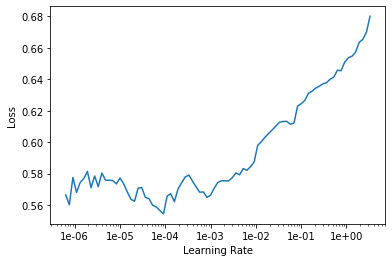

In [27]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [28]:
learn.unfreeze()

In [28]:
learn.fit_one_cycle(50, max_lr=slice(1e-7, 5e-5))

In [29]:
learn.model = learn.model.module
learn.save('resnet152_1024_lg_unfreeze_v02')

In [28]:
learn = cnn_learner(data, models.resnet152, metrics=accuracy, bn_final=True, ps=0.05).load('resnet152_1024_lg_unfreeze_v02')
learn.model = torch.nn.DataParallel(learn.model)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


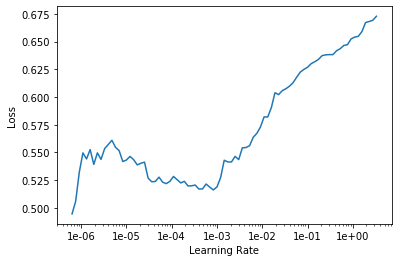

In [33]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [29]:
learn.fit_one_cycle(10, max_lr=slice(1e-5, 1e-4))

In [30]:
learn.model = learn.model.module
learn.save('resnet152_1024_lg_unfreeze_v03')

In [26]:
learn = cnn_learner(data, models.resnet152, metrics=accuracy, bn_final=True, ps=0.5).load('resnet152_1024_lg_unfreeze_v03')
learn.model = torch.nn.DataParallel(learn.model)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


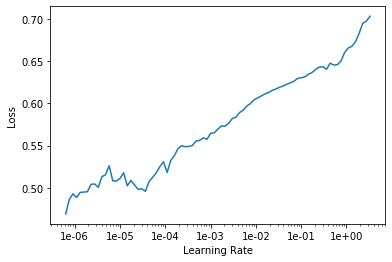

In [27]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(10, max_lr=slice(1e-7, 1e-5))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


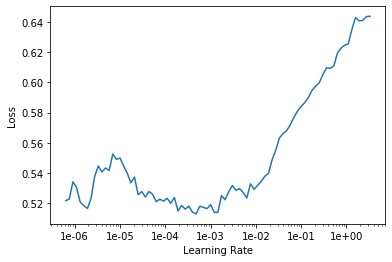

In [27]:
learn = cnn_learner(data, models.resnet152, metrics=accuracy, bn_final=True, ps=0.05).load('resnet152_1024_lg_unfreeze_v03')
learn.model = torch.nn.DataParallel(learn.model)

In [ ]:
learn.freeze()
learn.lr_find()
learn.recorder.plot()

In [28]:
learn.fit_one_cycle(10, max_lr=slice(5e-5))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


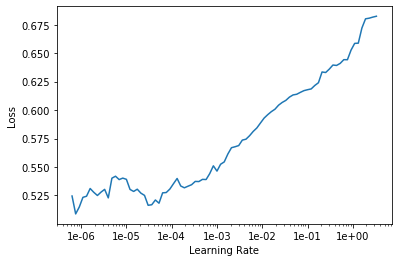

In [36]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [37]:
learn.fit_one_cycle(40, max_lr=slice(1e-7, 2e-6))

In [38]:
learn.fit_one_cycle(4, max_lr=slice(1e-7, 2e-6))

In [28]:
learn.fit_one_cycle(1, slice(1e-5))

In [29]:
learn.model = learn.model.module
learn.save('resnet152_1024_lg_unfrz_1_1_epoch')

In [ ]:
learn = cnn_learner(data, models.resnet152, metrics=accuracy, bn_final=True, ps=0.5).load('resnet152_1024_lg_head_40_epochs')
learn.model = torch.nn.DataParallel(learn.model)

In [36]:
learn.fit_one_cycle(5, slice(1e-7, 1e-4))

In [37]:
learn.freeze_to(-100)

In [38]:
learn.fit_one_cycle(10, slice(1e-7, 1e-4), pct_start=0.8)

In [39]:
learn.unfreeze()

In [40]:
learn.fit_one_cycle(10, slice(1e-7, 1e-4))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


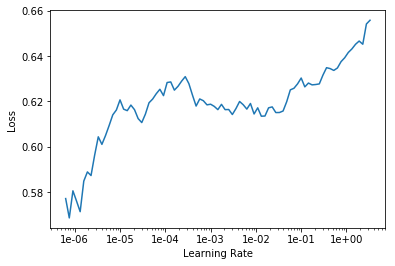

In [41]:
learn.lr_find()
learn.recorder.plot()

In [47]:
learn.fit_one_cycle(5, slice(1e-6))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


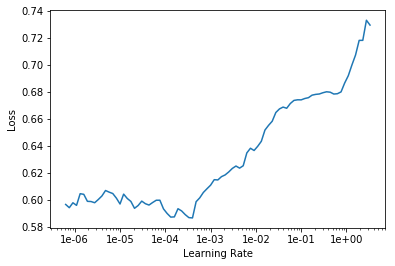

In [48]:
learn.lr_find()
learn.recorder.plot()

In [50]:
learn.unfreeze()
learn.fit_one_cycle(10, max_lr=slice(1e-7, 1e-4))

In [24]:
data = ImageDataBunch.from_df(path_to_images, 
                              dfs[['filename_new', 'treatment']],
                              ds_tfms=get_transforms(),
                              valid_pct=VALID_PCT, 
                              bs=8,
                              size=1024).normalize(imagenet_stats)

# experimental
NUM_EPOCHS = 3
NUM_ITER_LAYERS = 11

learn = create_cnn(data, models.resnet152, metrics=accuracy, bn_final=True).load('resnet152_1024_lg')
learn.model = torch.nn.DataParallel(learn.model)

print('---------- First fit ----------\n')

learn.fit_one_cycle(NUM_EPOCHS, slice(1e-3))#, pct_start=0.8)
learn.save('resnet152_1024_lg_first_fit_v02')


layers_to_unfreeze = list((np.linspace(0, 150, NUM_ITER_LAYERS)).astype(int))[1:-1]

for iter_i in layers_to_unfreeze:
    print('\n---------- Unfreeze fit to -{} ----------\n'.format(iter_i))
    learn.freeze_to(-iter_i)
    learn.fit_one_cycle(NUM_EPOCHS, max_lr=slice(1e-6,1e-3), pct_start=0.8)
#    learn.fit_one_cycle(NUM_EPOCHS, max_lr = slice(1e-6, 1e-4), moms=(0.8, 0.7))
    learn.save('new_resnet152_1024_unfreeze_to_minus_' + str(iter_i))

learn.unfreeze()
learn.fit_one_cycle(NUM_EPOCHS, max_lr=slice(1e-6,1e-3))
learn.save('resnet152_1024_lg_v02')

---------- First fit ----------




---------- Unfreeze fit to -15 ----------




---------- Unfreeze fit to -30 ----------




---------- Unfreeze fit to -45 ----------




---------- Unfreeze fit to -60 ----------




---------- Unfreeze fit to -75 ----------




---------- Unfreeze fit to -90 ----------




---------- Unfreeze fit to -105 ----------




---------- Unfreeze fit to -120 ----------




---------- Unfreeze fit to -135 ----------



In [20]:
data = ImageDataBunch.from_df(path_to_images, 
                              symmetrise_data(dfs[['filename_new', 'treatment']], remove_one=True),
                              ds_tfms=get_transforms(),
                              valid_pct=VALID_PCT, 
                              bs=8,
                              size=1024).normalize(imagenet_stats)

# experimental
NUM_EPOCHS = 10
NUM_ITER_LAYERS = 11

learn = create_cnn(data, models.resnet152, metrics=accuracy, bn_final=True).load('resnet152_1024_lg')
learn.model = torch.nn.DataParallel(learn.model)

print('---------- First fit ----------\n')

learn.fit_one_cycle(NUM_EPOCHS, slice(1e-2), pct_start=0.8)

layers_to_unfreeze = list((np.linspace(0, 150, NUM_ITER_LAYERS)).astype(int))[1:-1]

for iter_i in layers_to_unfreeze:
    print('---------- Unfreeze fit to -{} ----------\n'.format(iter_i))
    learn.freeze_to(-iter_i)
    learn.fit_one_cycle(NUM_EPOCHS, max_lr=slice(1e-6,1e-3), pct_start=0.8)
#    learn.fit_one_cycle(NUM_EPOCHS, max_lr = slice(1e-6, 1e-4), moms=(0.8, 0.7))
    learn.save('resnet152_1024_unfreeze_to_minus_' + str(iter_i))

learn.unfreeze()
learn.fit_one_cycle(NUM_EPOCHS, max_lr=slice(1e-6,1e-3))

---------- First fit ----------



---------- Unfreeze fit to -30 ----------



---------- Unfreeze fit to -60 ----------



---------- Unfreeze fit to -90 ----------



---------- Unfreeze fit to -120 ----------



In [21]:
learn.save('resnet152_1024_lg')

In [26]:
# https://github.com/fastai/course-v3/blob/master/nbs/dl1/lesson6-pets-more.ipynb

In [36]:
learn = create_cnn(data, models.resnet152, metrics=accuracy, bn_final=True).load('resnet152_512_lg_bn_final')
learn.model = torch.nn.DataParallel(learn.model)

In [37]:
learn.fit_one_cycle(1, slice(1e-4))

RuntimeError: CUDA out of memory. Tried to allocate 16.00 MiB (GPU 0; 10.92 GiB total capacity; 10.14 GiB already allocated; 9.25 MiB free; 165.20 MiB cached)

In [27]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-3))

In [22]:
learn.fit_one_cycle(3, slice(1e-2), pct_start=0.8)

In [23]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(1, max_lr=())

In [25]:
learn.freeze_to(-30)
learn.fit_one_cycle(NUM_EPOCHS, max_lr = slice(1e-6, 1e-4), moms=(0.8, 0.7))

In [26]:
learn.freeze_to(-60)
learn.fit_one_cycle(NUM_EPOCHS, max_lr = slice(1e-6, 1e-4), moms=(0.8, 0.7))

In [27]:
learn.freeze_to(-90)
learn.fit_one_cycle(NUM_EPOCHS, max_lr = slice(1e-6, 1e-4), moms=(0.8, 0.7))

In [28]:
learn.freeze_to(-120)
learn.fit_one_cycle(NUM_EPOCHS, max_lr = slice(1e-6, 1e-4), moms=(0.8, 0.7))

In [29]:
learn.unfreeze()
learn.fit_one_cycle(NUM_EPOCHS, max_lr = slice(1e-6, 1e-4), moms=(0.8, 0.7))

In [24]:
learn = create_cnn(data, models.resnet152, metrics=accuracy, bn_final=True)
#learn.load('resnet152_512_lg_bn_final');
#learn.load('resnet152_1024');
learn.model = torch.nn.DataParallel(learn.model)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


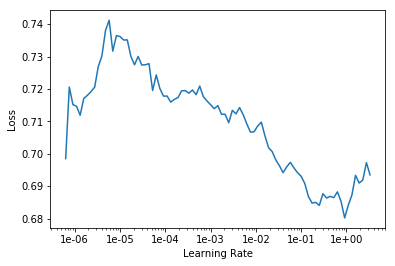

In [25]:
learn.lr_find()
learn.recorder.plot()

In [25]:
learn.fit_one_cycle(10)

KeyboardInterrupt: 

In [ ]:
learn.model = learn.model.module
learn.save('resnet152_1024_froz')

In [ ]:
learn = create_cnn(data, models.resnet152, metrics=accuracy)
learn.load('resnet152_1024_froz');
learn.model = torch.nn.DataParallel(learn.model)

In [28]:
NUM_EPOCHS = 10

In [ ]:
# will fit in five batches, each approx 30

In [ ]:
learn.freeze_to(-30)
#learn.lr_find()
#learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(NUM_EPOCHS, max_lr = slice(1e-6, 1e-4), moms=(0.8, 0.7))

In [23]:
learn.model = learn.model.module
learn.save('resnet152_1024_unfroz_30')

In [24]:
learn = create_cnn(data, models.resnet152, metrics=accuracy)
learn.load('resnet152_1024_unfroz_30');
learn.model = torch.nn.DataParallel(learn.model)

In [ ]:
learn.freeze_to(-60)
#learn.lr_find()
#learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(NUM_EPOCHS, max_lr = slice(1e-6, 1e-4), moms=(0.8, 0.7))

In [30]:
learn.model = learn.model.module
learn.save('resnet152_1024_unfroz_60')

In [31]:
learn = create_cnn(data, models.resnet152, metrics=accuracy)
learn.load('resnet152_1024_unfroz_60');
learn.model = torch.nn.DataParallel(learn.model)

In [ ]:
learn.freeze_to(-90)
#learn.lr_find()
#learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(NUM_EPOCHS, max_lr = slice(1e-6, 1e-4), moms=(0.8, 0.7))

In [34]:
learn.model = learn.model.module
learn.save('resnet152_1024_unfroz_90')

In [35]:
learn = create_cnn(data, models.resnet152, metrics=accuracy)
learn.load('resnet152_1024_unfroz_90');
learn.model = torch.nn.DataParallel(learn.model)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


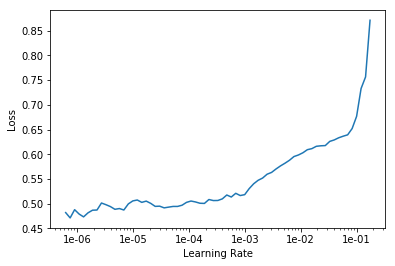

In [36]:
learn.freeze_to(-120)
learn.lr_find()
learn.recorder.plot()

In [37]:
learn.fit_one_cycle(NUM_EPOCHS, max_lr = slice(1e-6, 1e-4), moms=(0.8, 0.7))

In [38]:
learn.model = learn.model.module
learn.save('resnet152_1024_unfroz_120')

In [39]:
learn = create_cnn(data, models.resnet152, metrics=accuracy)
learn.load('resnet152_1024_unfroz_120');
learn.model = torch.nn.DataParallel(learn.model)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


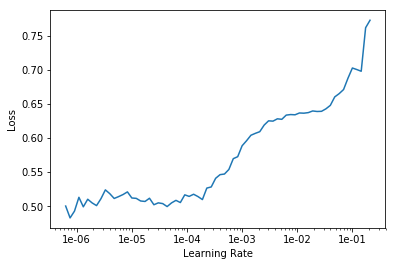

In [40]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [41]:
learn.fit_one_cycle(NUM_EPOCHS, max_lr = slice(1e-6, 1e-4), moms=(0.8, 0.7))

In [42]:
learn.model = learn.model.module
learn.save('resnet152_1024')

In [47]:
learn = create_cnn(data, models.resnet152, metrics=accuracy)
learn.load('resnet152_1024');
learn.model = torch.nn.DataParallel(learn.model)

In [48]:
learn.unfreeze()

In [50]:
learn.fit_one_cycle(20, max_lr = slice(1e-5/18, 1e-5))

In [51]:
learn.model = learn.model.module
learn.save('resnet152_1024')

In [ ]:
#learn.model = learn.model.module
#learn.save('resnet152_1024')

In [27]:
#learn.model = torch.nn.DataParallel(learn.model)

In [30]:
data = ImageDataBunch.from_df(base_path, 
                              df_data_images_cy5_bs_8,
                              ds_tfms=get_transforms(), 
                              valid_pct=0.2,
                              bs=BS,
                              size=1024).normalize(imagenet_stats)

In [31]:
learn = create_cnn(data, models.resnet152, metrics=accuracy)
learn.load('resnet152_1024_bs_' + str(BS) + '_module');
learn.model = torch.nn.DataParallel(learn.model)

In [53]:
learn.fit_one_cycle(5, slice(1e-5, 2e-4))

In [54]:
learn.save('resnet152_1024')

In [ ]:
# returns 'a normal' model after DataParallel
learn.model = learn.model.module

In [52]:
ci = ClassificationInterpretation.from_learner(learn)

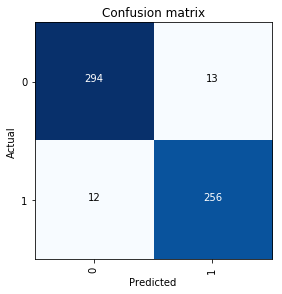

In [53]:
ci.plot_confusion_matrix()

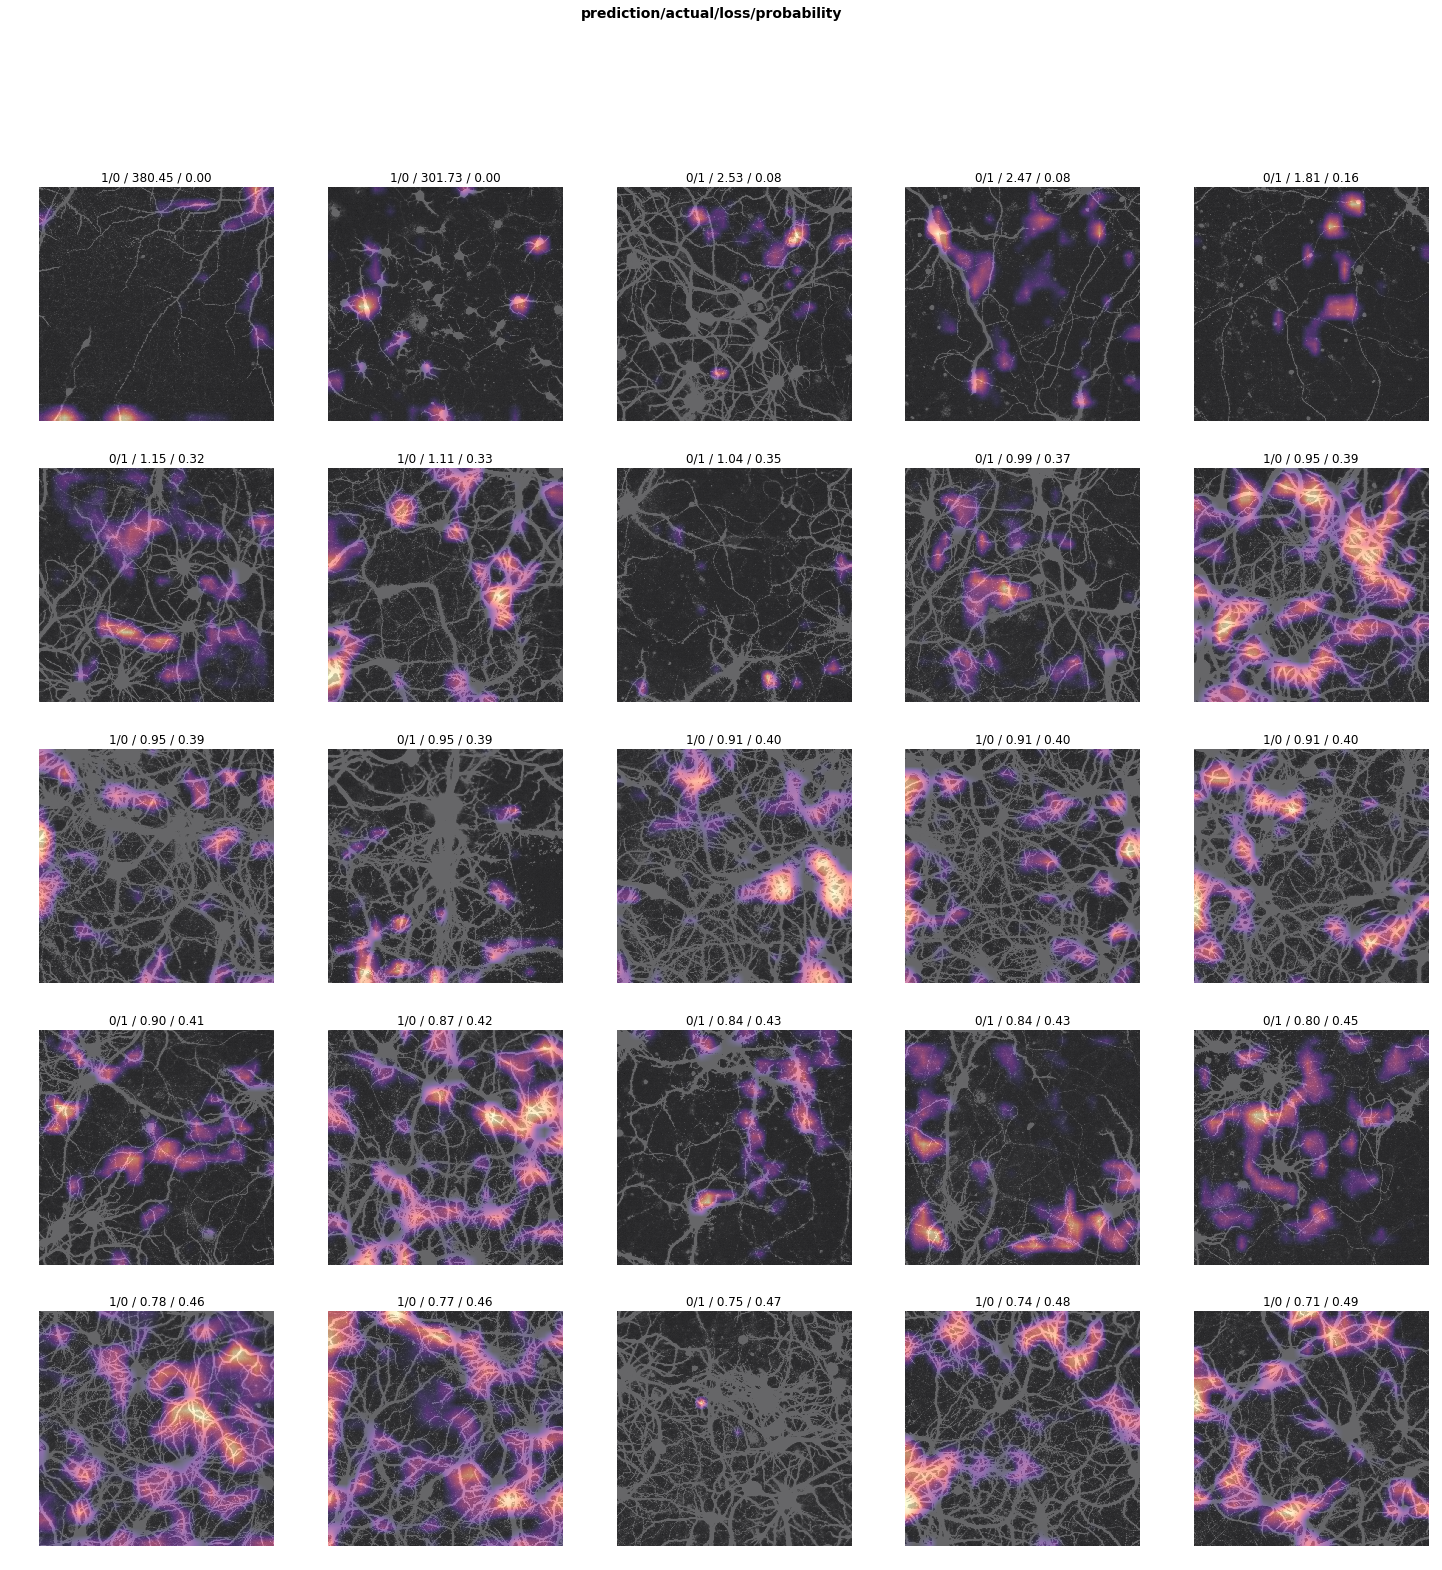

In [54]:
ci.plot_top_losses(25, figsize=(25,25))

## Training at MAX resolution

In [19]:
new_df = pd.concat([df_data_images_cy5[df_data_images_cy5.label==0].sample(1432), df_data_images_cy5[df_data_images_cy5.label==0].sample(1432)]).reset_index(drop=True).copy()

In [20]:
data = ImageDataBunch.from_df(base_path, 
                              new_df, #df_data_images_cy5,
                              ds_tfms=get_transforms(), 
                              valid_pct=0.2,
                              bs=8,
                              size=1200).normalize(imagenet_stats)

In [21]:
learn = create_cnn(data, models.resnet152, metrics=accuracy)
learn.load('resnet152_1024');
learn.freeze()

RuntimeError: Error(s) in loading state_dict for Sequential:
	size mismatch for 1.8.weight: copying a param with shape torch.Size([2, 512]) from checkpoint, the shape in current model is torch.Size([1, 512]).
	size mismatch for 1.8.bias: copying a param with shape torch.Size([2]) from checkpoint, the shape in current model is torch.Size([1]).

In [ ]:
learn.model = torch.nn.DataParallel(learn.model)

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(3, 5e-6)

In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(3, slice(1e-6, 1e-4))

In [ ]:
learn.save('resnet152_2048')

In [ ]:
# returns 'a normal' model after DataParallel
learn.model = learn.model.module

In [ ]:
ci = ClassificationInterpretation.from_learner(learn)

In [ ]:
ci.plot_confusion_matrix()

In [ ]:
ci.plot_top_losses(25, figsize=(25,25))

# Training at 1536 resolution

In [40]:
data = ImageDataBunch.from_df(path_to_images, 
                              symmetrise_data(dfs[['filename_new', 'treatment']], remove_one=False             
                                             ),
                              ds_tfms=get_transforms(do_flip=True, 
                                                     flip_vert=True, 
                                                     max_rotate=None, 
                                                     max_zoom=1.0, 
                                                     max_warp=None),
                              valid_pct=VALID_PCT, 
                              bs=9,
                              size=1600).normalize(imagenet_stats)

In [41]:
learn = cnn_learner(data, models.resnet152, metrics=accuracy, bn_final=True, ps=0.5).load('resnet152_1024_lg_first_fit_v03').to_fp16()
learn.model = torch.nn.DataParallel(learn.model)

In [42]:
learn.lr_find()
learn.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


RuntimeError: CUDA out of memory. Tried to allocate 236.00 MiB (GPU 0; 10.92 GiB total capacity; 10.06 GiB already allocated; 69.50 MiB free; 175.95 MiB cached)